In [1]:
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from scipy import special

In [2]:
def Voigt(x, x0, sigma, gamma):
    '''
    x should be an array.
    sigma is the Doppler parameter.
    gamma is the Gaussian sigma.
    x0 is the center position.
    '''
    z = ((x-x0) + 1j * abs(gamma)) / abs(sigma) / 2**0.5

    return (special.wofz(z)).real/abs(sigma)/(2*np.pi)**0.5

def vline(x, p):
    '''
    p = [sigma, gamma, tau, v0, covering_factor]
    saturated_factor is a newly defined parameter to describe the thermal radiation varying in 0 to 1.
    The simplified model is c_f * exp(-tau) + (1-c_f).
    '''
    x = np.array(x)
    pro = abs(p[2]) * Voigt(x, p[3], p[0], abs(p[1]))

    return abs(p[4]) * np.exp(-pro) + (1 - abs(p[4]))

def convolve(model, lsf):
    Nlsf = len(lsf) // 2
    ext_model = np.append(np.ones(Nlsf)*model[0], model)
    ext_model = np.append(ext_model, np.ones(Nlsf)*model[-1])
    cmodel = np.convolve(ext_model, lsf, 'valid')
    return cmodel

def N2tau(N, wlr, f):
    tau = N * 2.654e-15 * f * wlr
    return tau

def model(p0):
    m1 = np.ones(v1.shape)
    m2 = np.ones(v2.shape)
    Ncomp = len(p0)//3
    for comp_i in range(Ncomp):
        N, b, vc = p0[comp_i*3: comp_i*3+3]
        m1 = m1*vline(v1, [b/1.414, gamma1, N2tau(10**N, wl1, f1), vc, 1])
        m2 = m2*vline(v2, [b/1.414, gamma2, N2tau(10**N, wl2, f2), vc, 1])

    m1 = convolve(m1, lsf)
    m2 = convolve(m2, lsf)

    return m1, m2

def fitting(p0):
    m1, m2 = model(p0)
    chi1 = (fn1 - m1) / fne1
    chi2 = (fn2 - m2) / fne2

    chi1 = chi1[(v1 < 200) & (v1 > -200)]
    chi2 = chi2[(v2 < 200) & (v2 > -200)]

    return np.append(chi1, chi2)

def plot_model(p0):
    m1, m2 = model(p0)
    plt.step(v1, fn1+1, 'k-', lw=2, where='mid')
    plt.plot(v1, m1+1, 'r--', lw=2)
    plt.hlines(1, -400, 400, linestyles='dashed', colors='c')
    plt.step(v2, fn2, 'k-', lw=2, where='mid')
    plt.plot(v2, m2, 'r--', lw=2)
    plt.hlines(2, -400, 400, linestyles='dashed', colors='c')

    Ncomp = len(p0)//3
    for comp_i in range(Ncomp):
        N, b, vc = p0[comp_i*3: comp_i*3+3]
        m1 = vline(v1, [b/1.414, gamma1, N2tau(10**N, wl1, f1), vc, 1])
        m2 = vline(v2, [b/1.414, gamma2, N2tau(10**N, wl2, f2), vc, 1])

        m1 = convolve(m1, lsf)
        m2 = convolve(m2, lsf)
        plt.plot(v1, m1+1, 'y:', lw=2)
        plt.plot(v2, m2, 'y:', lw=2)

    plt.xlim(-400, 400)
    plt.show()
    
def N_v(fn, wlr, f):
    return -np.log(fn)/wlr/f/2.654e-15

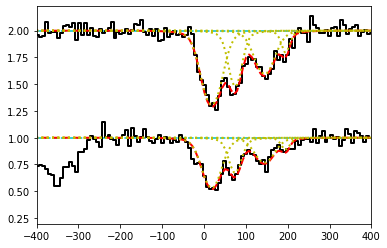

In [3]:
lsf = np.loadtxt('FAIRALL9/CIV.lsf')

v1, f1, fe1, ctn1 = np.loadtxt('FAIRALL9/CIV1548.bin3.linespec').transpose()
fn1 = f1 / ctn1
fne1 = fe1 / ctn1
v2, f2, fe2, ctn2 = np.loadtxt('FAIRALL9/CIV1550.bin3.linespec').transpose()
fn2 = f2 / ctn2
fne2 = fe2 / ctn2

wl1, f1, gamma1, elem, state = (1548.187, 0.19, 0.00324, 'C', 'IV')
wl2, f2, gamma2, elem, state = (1550.772, 0.0952, 0.00325, 'C', 'IV')

x0 = [13.5, 20.3, -20] + [13.5, 20.3, 40] + [13, 20.3, 150] + [13, 20.3, 170]
p0, cov, a, b, c = leastsq(fitting, x0, full_output=1)

plot_model(p0)

In [4]:
N1 = 10**(p0[0])*Voigt(v1, p0[2], p0[1]/np.sqrt(2), gamma1)
N2 = 10**(p0[3])*Voigt(v1, p0[5], p0[4]/np.sqrt(2), gamma1)
N3 = 10**(p0[6])*Voigt(v1, p0[8], p0[7]/np.sqrt(2), gamma1)
N4 = 10**(p0[9])*Voigt(v1, p0[11], p0[10]/np.sqrt(2), gamma1)
N_tot = N1+N2+N3+N4

N1w = 10**(p0[0])*Voigt(v2, p0[2], p0[1]/np.sqrt(2), gamma2)
N2w = 10**(p0[3])*Voigt(v2, p0[5], p0[4]/np.sqrt(2), gamma2)
N3w = 10**(p0[6])*Voigt(v2, p0[8], p0[7]/np.sqrt(2), gamma2)
N4w = 10**(p0[9])*Voigt(v2, p0[11], p0[10]/np.sqrt(2), gamma2)
N_totw = N1w+N2w+N3w+N4w

Text(0.5, 1.0, 'Strong Components')

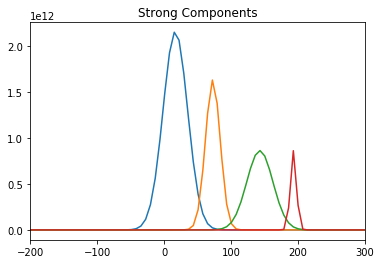

In [5]:
plt.plot(v1,N1)
plt.plot(v1,N2)
plt.plot(v1,N3)
plt.plot(v1,N4)
plt.xlim(-200, 300)
plt.title('Strong Components')

(-200, 300)

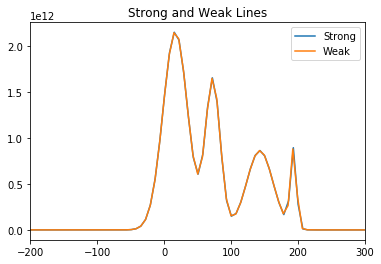

In [6]:
plt.plot(v1, N_tot, label='Strong')
plt.plot(v2, N_totw, label='Weak')
plt.legend()
plt.title('Strong and Weak Lines')
plt.xlim(-200, 300)

In [7]:
m1, m2 = model(p0)

r1 = fn1 / m1
r2 = fn2 / m2

N_r_s = N_v(r1, wl1, f1)
N_r_w = N_v(r2, wl2, f2)

(-200, 300)

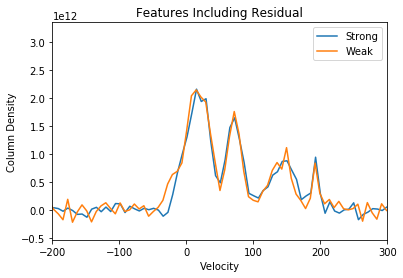

In [8]:
plt.plot(v1, N_tot + N_r_s, label='Strong')
plt.plot(v2, N_totw + N_r_w, label='Weak')
plt.legend()
plt.xlabel('Velocity')
plt.ylabel('Column Density')
plt.title('Features Including Residual')

plt.xlim(-200, 300)